In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn
# reload and re-train to full convergence
%run notebooks/reload

from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from notebooks.runAmber import get_uniform_ms, get_finkelstein_ms

import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wut9vcsf because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


0.1.1-ga


Using TensorFlow backend.


In [2]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')
with open('./data/y_col_annot.txt', 'r') as f:
    label_annot = [x.strip() for x in f]
    label_annot = {x:i for i,x in enumerate(label_annot)}
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)
target_idx = label_annot['wtCas9_cleave_rate_log']
label_annot

{'wtCas9_cleave_rate_log': 0,
 'Cas9_enh_cleave_rate_log': 1,
 'Cas9_hypa_cleave_rate_log': 2,
 'Cas9_HF1_cleave_rate_log': 3,
 'wtCas9_cleave_rate_log_specificity': 4,
 'Cas9_enh_cleave_rate_log_specificity': 5,
 'Cas9_hypa_cleave_rate_log_specificity': 6,
 'Cas9_HF1_cleave_rate_log_specificity': 7,
 'wtCas9_ndABA': 8,
 'Cas9_enh_ndABA': 9,
 'Cas9_hypa_ndABA': 10,
 'Cas9_HF1_ndABA': 11}

In [3]:
kinn_model_space = get_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [30]:
mb = reload_from_dir("outputs/notebook", replace_conv_by_fc=False, n_channels=8)
model = mb.model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0_3 (InputLayer)          [(None, 3, 8)]       0                                            
__________________________________________________________________________________________________
input_7_16 (InputLayer)         [(None, 9, 8)]       0                                            
__________________________________________________________________________________________________
input_3_11 (InputLayer)         [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
input_17_24 (InputLayer)        [(None, 7, 8)]       0                                            
____________________________________________________________________________________________

In [31]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)
wd = "outputs/notebook"
y_hat = model.predict(x_test_b).flatten()
test_pcc = ss.pearsonr(y_hat, y_test[:,target_idx])[0]

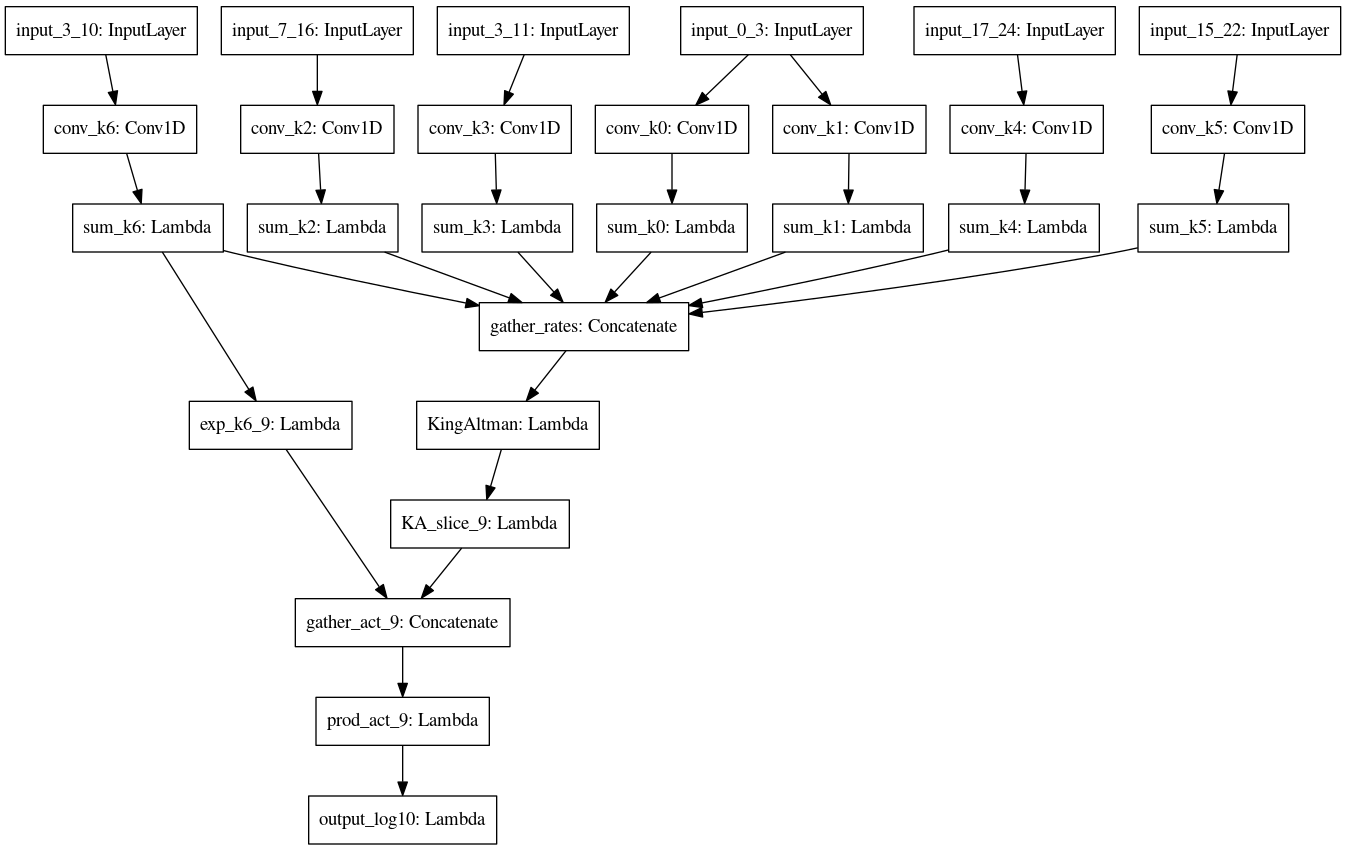

In [32]:
tf.keras.utils.plot_model(model)

In [33]:
mb.kinn.get_ka_pattern_mat()

array([[0., 1., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 0.]])

In [34]:
layer_dict = {l.name:l for l in model.layers}

In [35]:
rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=
                                 [layer_dict["sum_k%i"%k].output for k in range(7)])

In [36]:
print('sgRNA1\n', x_train[1,0:8, 0:4])
print('sgRNA2\n', x_train[0,0:8, 0:4])

sgRNA1
 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
sgRNA2
 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [37]:
matched = np.concatenate([x_train[[1,0], :, 0:4], np.zeros((2,25,4))], axis=-1)
matched_b = mb.blockify_seq_ohe(matched)
matched_b[0]

array([[[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]]])

In [38]:
model.predict(matched_b)

array([[-3.7709334],
       [-4.0201197]], dtype=float32)

In [39]:
a = rate_mod.predict(matched_b)
print("   sgRNA_1   snRNA_2")
for i in range(7):
    r = a[i]
    print("k_%i"%i, r.flatten())
# activity
#print("act", a[7].flatten())

   sgRNA_1   snRNA_2
k_0 [-2.1473446 -2.1473446]
k_1 [2.8620214 2.8620214]
k_2 [3.5452936 2.752993 ]
k_3 [5.693591  5.5691195]
k_4 [-1.3985838 -1.359355 ]
k_5 [-0.22807595 -0.63198125]
k_6 [1.8583987 2.1006007]


In [40]:
r = rate_mod.predict([x_test_b[i] for i in range(len(x_train_b))])

In [41]:
y_test[0:20, target_idx]

array([-5.        , -3.84858724, -5.        , -5.        , -5.        ,
       -3.69597072, -2.31258181, -5.        , -3.28703816, -4.86598589,
       -3.88005823, -4.07122425, -4.95645846, -5.        , -2.28959828,
       -5.        , -2.293807  , -3.94799902, -5.        , -1.80381751])

In [45]:
i = 0
{"k%i"%_:r[_][i][0] for _ in range(len(r))}

{'k0': -4.0853305,
 'k1': 4.8053265,
 'k2': 2.752993,
 'k3': 5.5691195,
 'k4': -1.359355,
 'k5': -0.63198125,
 'k6': 2.1006007}

In [46]:
def pretty_print(mat):
    for i, r in enumerate(mat):
        h, t = r[0:4], r[4:]
        try:
            ref = 'ACGT'[np.where(h==1)[0][0]]
        except:
            continue
        if sum(t) == 0:
            edit = ''
        else:
            edit = '->' + 'ACGT'[np.where(t==1)[0][0]]

        print('row %i\t'%i, ref, edit)
        #print('row ', i, r)

pretty_print(x_test[i])

row 0	 G ->A
row 1	 G ->C
row 2	 T 
row 3	 G 
row 4	 T 
row 5	 A 
row 6	 C 
row 7	 C 
row 8	 G 
row 9	 T 
row 10	 A 
row 11	 A 
row 12	 G 
row 13	 G 
row 14	 T 
row 15	 G 
row 16	 A 
row 17	 A 
row 18	 T 
row 19	 A 
row 20	 G 
row 21	 T 
row 22	 G 


In [47]:
print("obs ", y_test[i, target_idx], "; pred ",y_hat[i])

obs  -5.0 ; pred  -5.7024355
